<a href="https://colab.research.google.com/github/jakesong16/Breast-Cancer-Classification-with-Machine-Learning/blob/main/Predicting_Stocks_using_NLP_and_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Preparation**

In [3]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
!pip install transformers
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

%matplotlib inline

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(14,12))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
--2023-08-07 18:34:32--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv’

finance_test.csv    100%[===================>]  28.58K  --.-KB/s    in 0s      

2023-08-07 18:34:33 (157 MB/s) - ‘finance_test.csv’ saved [29264/29264]

--2023-08-07 

# **Preprocessing data for BERT and training our model.**



In [4]:
df_train = get_finance_train()
df_test = get_finance_test()

In [5]:
sentences = df_train["Sentence"]
labels = df_train["Label"]

0       Autotank Group is part of Aspo 's Systems Divi...
1       The contract includes design , construction , ...
2       Rapala said it estimates it will make savings ...
3       The share capital of Alma Media Corporation (b...
4       The financial impact is estimated to be some 1...
                              ...                        
2032    Net sales increased to EUR193 .3 m from EUR179...
2033    Operating profit totalled EUR 9.0 mn , down fr...
2034    Cash flow from operations in January-December ...
2035    In the first quarter of 2010 , the mark-to-mar...
2036    Currently the quarterly applied surcharges dif...
Name: Sentence, Length: 2037, dtype: object


## **Tokenization & Input Formatting**

#### Step 1 : Create the Tokenizer ####

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [7]:
original_sentence = sentences[0]
tokenized = tokenizer.tokenize(original_sentence)

Autotank Group is part of Aspo 's Systems Division .
['auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.']


#### Step 2 : Map the tokens to our index ####

In [8]:
indices = tokenizer.convert_tokens_to_ids(tokenized)

['auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.']
[8285, 5794, 2243, 2177, 2003, 2112, 1997, 2004, 6873, 1005, 1055, 3001, 2407, 1012]


### Text Formatting ###

When using BERT, we need to modify our input to match the BERT Format. To do so, we will apply these three steps on the input sentences:

1. Add special tokens to the start (`[CLS]`) and end (`[SEP]`) of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

Take note of the visualization on **Sentence A** below that elucidates these steps. However, let us understand each of these steps in more detail before proceeding to apply them to our dataset.

In [9]:
sentences_with_special_tokens = []
for sentence in sentences:
  new_sentence = "[CLS] " + sentence + " [SEP]"
  sentences_with_special_tokens.append(new_sentence)


In [10]:
tokenized_texts = []
for sentence in sentences_with_special_tokens:
  new_tokenized_sentence = tokenizer.tokenize(sentence)
  tokenized_texts.append(new_tokenized_sentence)

In [11]:
input_ids = []
for text in tokenized_texts:
  corresponding_indices = tokenizer.convert_tokens_to_ids(text)
  input_ids.append(corresponding_indices)


In [12]:
input_ids = pad_sequences(input_ids,
                          maxlen=128,
                          dtype="long",
                          truncating="post",
                          padding="post")

[ 101 8285 5794 2243 2177 2003 2112 1997 2004 6873 1005 1055 3001 2407
 1012  102    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [13]:
attention_masks = []

for sequence in input_ids:
    mask_sequence = [1.0 if value > 0 else 0.0 for value in sequence]
    attention_masks.append(mask_sequence)


## **Setting up your Data for BERT**

In [14]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size = 0.15, random_state = RND_SEED)

In [15]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size = 0.15, random_state = RND_SEED)

In [16]:
#@title Run this cell to convert data to tensors and create DataLoaders
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); # Samples data randonly for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); # Samples data sequentially
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

# **Running and finetuning our BERT model with the PyTorch huggingface transformer library.**





In [17]:
#@title Run this cell to initialize your BertForSequenceClassification model
#Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT small model, with an uncased vocab.
    num_labels = 3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
);

# Given that this a huge neural network, we need to explicity specify
# in pytorch to run this model on the GPU.
model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'Tesla T4'

In [18]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
epochs = 4

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
#@title train your model

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# We'll store training and validation loss,
# validation accuracy, and timings.
training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode.
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # STEP 1 & 2: Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # STEP 3
        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # STEP 4
        # Perform a forward pass (evaluate the model on this training batch).
        # It returns the loss (because we provided labels) and
        # the "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # STEP 5
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # STEP 6
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Evaluating on Validation Set")
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        # Unpack this validation batch from our dataloader.

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("Validation Loss: {0:.2f}".format(avg_val_loss))


    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.71
Evaluating on Validation Set
Validation Accuracy: 0.91
Validation Loss: 0.36
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.21
Evaluating on Validation Set
Validation Accuracy: 0.95
Validation Loss: 0.15
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.07
Evaluating on Validation Set
Validation Accuracy: 0.95
Validation Loss: 0.15
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.04
Evaluating on Validation Set
Validation Accuracy: 0.97
Validation Loss: 0.13
Training complete!


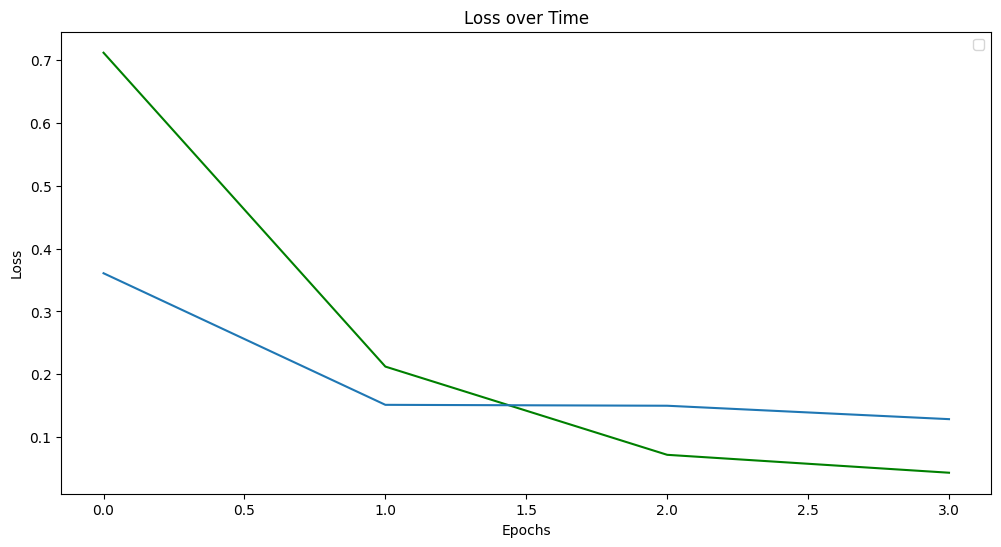

In [20]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, "green")
plt.plot(validation_loss)

plt.legend()
plt.show()

In [21]:
test_sentences = df_test["Sentence"]
test_labels = df_test["Label"]

In [22]:
#@title Run this cell to process and prepare our test data!
test_input_ids, test_attention_masks = [], []

# Add Special Tokens
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

# Tokenize sentences
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

# Encode Tokens to Word IDs
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

# Pad the inputs
test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

# Create Attention Masks
for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [23]:
#@title Run this cell to convert data to tensors and create DataLoaders
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Predicting labels for 227 test sentences...
Test Accuracy: 97.36%
Plotting the Confusion Matrix


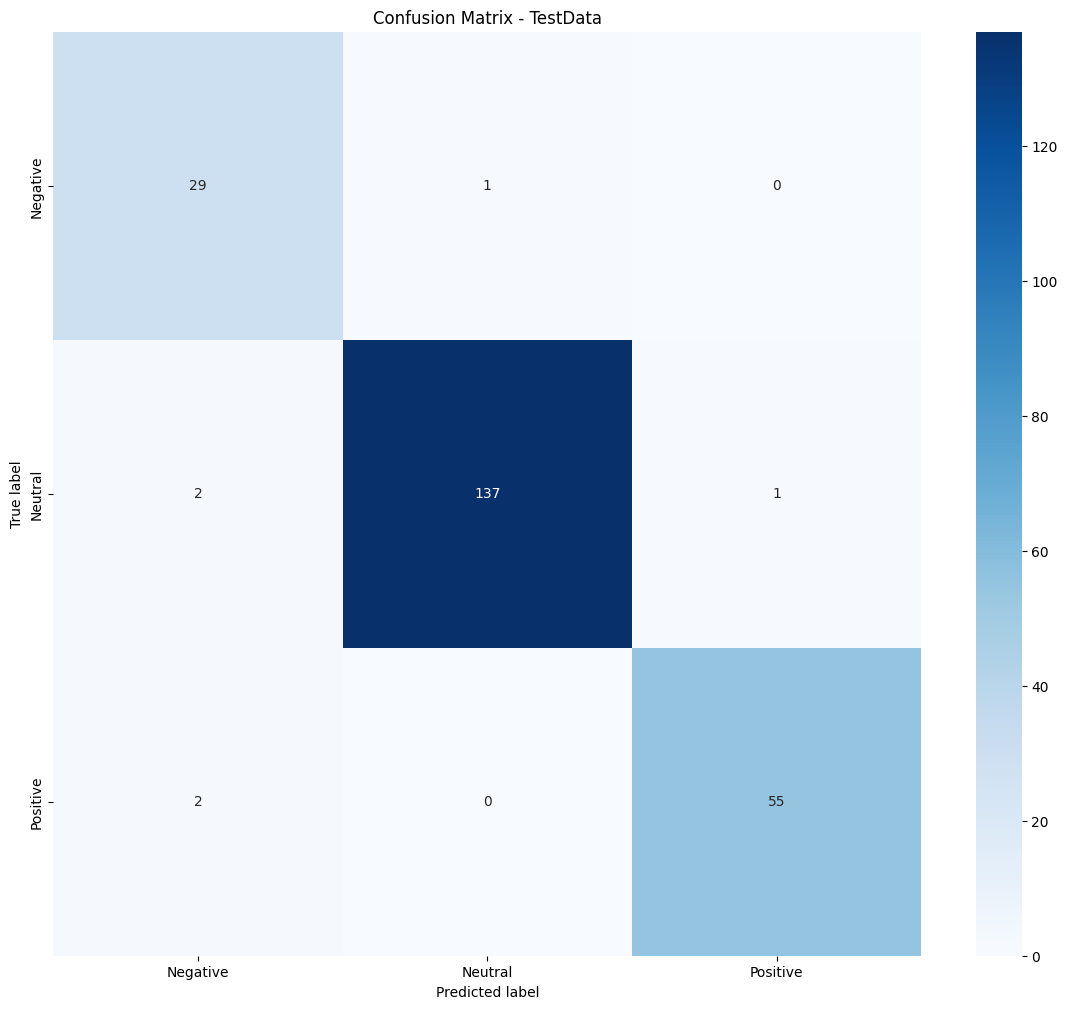

In [24]:
#@title Evaluate Test Set Accuracy!
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Final tracking variables
y_logits, y_true, y_preds = [], [], []

# Gather logit predictions
for chunk in predictions:
  for logits in chunk:
    y_logits.append(logits)

# Gather true labels
for chunk in true_labels:
  for label in chunk:
    y_true.append(label)

# Gather real predictions
for logits in y_logits:
  y_preds.append(np.argmax(logits))

print ('Test Accuracy: {:.2%}'.format(metrics.accuracy_score(y_preds,y_true)))
plot_confusion_matrix(y_true,y_preds)